Experiment 3: different angles

In [ ]:
!pip install deepface mediapipe
!pip install matplotlib

In [2]:
import cv2
import time
import os
import glob
from PIL import Image, ImageOps, ImageDraw
from deepface import DeepFace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import ipyplot

2024-03-28 09:26:08.133603: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 09:26:08.133664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 09:26:08.134901: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 09:26:08.244022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
input_folder = '/tf/data/upd_face_dataset'

In [4]:
model_names = [
    "VGG-Face",
    "Facenet",
    "Facenet512",
    "OpenFace",
    "DeepFace",
    "DeepID",
    "ArcFace",
    "SFace"
]
thresholds = {
     "VGG-Face": 1.17,
    "Facenet": 0.8,
    "Facenet512": 1.04,
    "OpenFace": 0.55,
    "DeepFace": 0.64,
    "DeepID": 0.17,
    "ArcFace": 1.13,
    "SFace": 1.055,
}
model_resolutions = {
    "VGG-Face": (224, 224),
    "Facenet": (220, 220),
    "Facenet512": (160, 160),
    "OpenFace": (96, 96),
    "DeepFace": (152, 152),
    "DeepID": (55, 47),
    "ArcFace": (112, 112),
    "SFace": (112, 112)
}
detector_backend = "retinaface"

In [11]:
def save_to_csv(data, columns, filename):
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename + '.csv', index=False)

  0%|          | 0/62 [00:00<?, ?it/s]

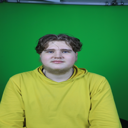

2024-03-21 19:55:15.257799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:61:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:55:15.447393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:61:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:55:15.447462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:61:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:55:15.456737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:61:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:55:15.456785: I tensorflow/compile

real run: comparing up/45_left/aabarstok/no_glasses.JPG with center/center/aabarstok/glasses.JPG, distance is 0.9465699558557209
45_left_up
real run: comparing up/center/aabarstok/no_glasses.JPG with center/center/aabarstok/glasses.JPG, distance is 1.0963719893916093
center_up
real run: comparing up/45_right/aabarstok/no_glasses.JPG with center/center/aabarstok/glasses.JPG, distance is 0.981561533946889
45_right_up


NameError: name 'df_results' is not defined

In [7]:
import random

users_list = os.listdir(os.path.join(input_folder, f"center/center/"))
horizontal_positions = ["45_left","center","45_right"]
vertical_positions = ["up","center","down"]

model_name = "VGG-Face"

for person_name in tqdm(users_list):
    person_distances = {"up": {"45_left": 0, "center": 0, "45_right": 0},
                        "center": {"45_left": 0, "center": 0, "45_right": 0},
                        "down": {"45_left": 0, "center": 0, "45_right": 0}}
    image_anfas_no_glasses_path = os.path.join(input_folder, f"center/center/{person_name}/no_glasses.JPG")
    image_anfas_no_glasses = Image.open(image_anfas_no_glasses_path)
    image_anfas_no_glasses = ImageOps.exif_transpose(image_anfas_no_glasses)
    display(image_anfas_no_glasses.resize((128, 128)))
    image_anfas_no_glasses = np.array(image_anfas_no_glasses)
    
    image_anfas_glasses_path = os.path.join(input_folder, f"center/center/{person_name}/glasses.JPG")
    yesGlasses =  os.path.exists(image_anfas_glasses_path)
    for vertical_position in vertical_positions:
        for horizontal_position in horizontal_positions:
            if vertical_position == horizontal_position:
                continue
            image_current_no_glasses_path = os.path.join(input_folder, f"{vertical_position}/{horizontal_position}/{person_name}/no_glasses.JPG")
            image_current_no_glasses = Image.open(image_current_no_glasses_path)
            image_current_no_glasses = ImageOps.exif_transpose(image_current_no_glasses)
            # ipyplot.plot_images([image_anfas_no_glasses, image_current_no_glasses], max_images=20, img_width=150)
            # display(image_current_no_glasses.resize((128, 128)))
            image_current_no_glasses = np.array(image_current_no_glasses)

            result = DeepFace.verify(
                img1_path=image_anfas_no_glasses,
                img2_path=image_current_no_glasses,
                enforce_detection=True,
                detector_backend="mediapipe",
                # detector_backend="ssd",
                model_name=model_name,
                distance_metric="euclidean_l2"
            )
            # print(f"dry run: comparing {vertical_position}/{horizontal_position}/{person_name}/no_glasses.JPG with center/center/{person_name}/glasses.JPG")
            print(f"real run: comparing {vertical_position}/{horizontal_position}/{person_name}/no_glasses.JPG with center/center/{person_name}/glasses.JPG, distance is {result['distance']}")
            person_distances[vertical_position][horizontal_position] = result['distance']
            if yesGlasses:
                image_current_glasses_path = os.path.join(input_folder, f"{vertical_position}/{horizontal_position}/{person_name}/glasses.JPG")               
                image_current_glasses = Image.open(image_current_glasses_path)
                image_current_glasses = ImageOps.exif_transpose(image_current_glasses)
                # ipyplot.plot_images([image_anfas_no_glasses, image_current_no_glasses], max_images=20, img_width=150)
                # display(image_current_glasses.resize((128, 128)))
                image_current_glasses = np.array(image_current_glasses)
            print(f'{horizontal_position}_{vertical_position}')
        # print(np.average(person_distances[vertical_position][horizontal_position]))
        # print(list(person_distances[vertical_position].values()))
        # print(np.average(list(person_distances[vertical_position].values())))
        # print(np.median(list(person_distances[vertical_position].values())))
        df_results.append(pd.DataFrame({'img_1': [img1_name], 'img_2': [img2_name], 'distance': [result['distance']], 'verified': [result['verified']]}))
    time.sleep(5)

In [12]:
def crop_to_square_pil(image, face_info):

    x, y, w, h = face_info['facial_area']['x'], face_info['facial_area']['y'], face_info['facial_area']['w'], face_info['facial_area']['h']

    square_size = max(w, h)
    new_x = max(0, x)
    new_y = max(0, y)
    cropped_image = image.crop((new_x - (h-w)//2, new_y, new_x - (h-w)//2 + square_size, new_y + square_size))

    return cropped_image

def resize_image_pil(image, new_resolution):
    resized_img = image.resize(new_resolution, Image.LANCZOS)
    return resized_img

In [ ]:
users_list = os.listdir(os.path.join(input_folder, f"center/center/"))
horizontal_positions = ["45_left","center","45_right"]
vertical_positions = ["up","center","down"]

for model_name, resolution in model_resolutions.items():
    print(f"model: {model_name}")
    df_results_model = []

    for person_name in tqdm(users_list):
        person_distances = {"up": {"45_left": 0, "center": 0, "45_right": 0},
                            "center": {"45_left": 0, "center": 0, "45_right": 0},
                            "down": {"45_left": 0, "center": 0, "45_right": 0}}

        image_anfas_no_glasses_path = os.path.join(input_folder, f"center/center/{person_name}/no_glasses.JPG")
        if not os.path.exists(image_anfas_no_glasses_path):
            continue
    
        image_anfas_no_glasses = Image.open(image_anfas_no_glasses_path)
        image_anfas_no_glasses = ImageOps.exif_transpose(image_anfas_no_glasses)
        face_info_anfas_no_glasses = DeepFace.extract_faces(img_path=image_anfas_no_glasses_path, detector_backend=detector_backend)
        cropped_image_anfas_no_glasses = crop_to_square_pil(image_anfas_no_glasses, face_info_anfas_no_glasses[0])
        resized_image_anfas_no_glasses = resize_image_pil(cropped_image_anfas_no_glasses, resolution)
        image_anfas_no_glasses = np.array(resized_image_anfas_no_glasses)

        image_anfas_glasses_path = os.path.join(input_folder, f"center/center/{person_name}/glasses.JPG")
        yesGlasses = os.path.exists(image_anfas_glasses_path)

        for vertical_position in vertical_positions:
            for horizontal_position in horizontal_positions:
                if vertical_position == horizontal_position:
                    continue
                image_current_no_glasses_path = os.path.join(input_folder, f"{vertical_position}/{horizontal_position}/{person_name}/no_glasses.JPG")
                if not os.path.exists(image_current_no_glasses_path):
                    continue
                image_current_no_glasses = Image.open(image_current_no_glasses_path)
                image_current_no_glasses = ImageOps.exif_transpose(image_current_no_glasses)
                face_info_current_no_glasses = DeepFace.extract_faces(img_path=image_current_no_glasses_path, detector_backend=detector_backend)
                cropped_image_current_no_glasses = crop_to_square_pil(image_current_no_glasses, face_info_current_no_glasses[0])
                resized_image_current_no_glasses = resize_image_pil(cropped_image_current_no_glasses, resolution)
                image_current_no_glasses = np.array(resized_image_current_no_glasses)
                # display(resized_image_current_no_glasses)

                result = DeepFace.verify(
                    img1_path=image_anfas_no_glasses,
                    img2_path=image_current_no_glasses,
                    enforce_detection=False,
                    detector_backend=detector_backend,
                    model_name=model_name,
                    distance_metric="euclidean_l2"
                )
                # print(f"real run: comparing {vertical_position}/{horizontal_position}/{person_name}/no_glasses.JPG with center/center/{person_name}/no_glasses.JPG, distance is {result['distance']}")
                person_distances[vertical_position][horizontal_position] = result['distance']

                if yesGlasses:
                    image_anfas_glasses = Image.open(image_anfas_glasses_path)
                    image_anfas_glasses = ImageOps.exif_transpose(image_anfas_glasses)
                    face_info_anfas_glasses = DeepFace.extract_faces(img_path=image_anfas_glasses_path, detector_backend=detector_backend)
                    cropped_image_anfas_glasses = crop_to_square_pil(image_anfas_glasses, face_info_anfas_glasses[0])
                    resized_image_anfas_glasses = resize_image_pil(cropped_image_anfas_glasses, resolution)
                    image_anfas_glasses = np.array(resized_image_anfas_glasses)
                   
                    image_current_glasses_path = os.path.join(input_folder, f"{vertical_position}/{horizontal_position}/{person_name}/glasses.JPG")
                    if not os.path.exists(image_current_glasses_path):
                        continue 
                    image_current_glasses = Image.open(image_current_glasses_path)
                    image_current_glasses = ImageOps.exif_transpose(image_current_glasses)
                    face_info_current_glasses = DeepFace.extract_faces(img_path=image_current_glasses_path, detector_backend=detector_backend)
                    cropped_image_current_glasses = crop_to_square_pil(image_current_glasses, face_info_current_glasses[0])
                    resized_image_current_glasses = resize_image_pil(cropped_image_current_glasses, resolution)
                    image_current_glasses = np.array(resized_image_current_glasses)
                    # display(resized_image_current_glasses)
                   
                    result_glasses = DeepFace.verify(
                        img1_path=image_anfas_glasses,
                        img2_path=image_current_glasses,
                        enforce_detection=False,
                        detector_backend=detector_backend,
                        model_name=model_name,
                        distance_metric="euclidean_l2"
                    )
                    # print(f"real run: comparing {vertical_position}/{horizontal_position}/{person_name}/glasses.JPG with center/center/{person_name}/glasses.JPG, distance is {result_glasses['distance']}")
                    person_distances[vertical_position][horizontal_position] = result_glasses['distance']
                    
                    df_results_model.append({
                        'model_name': model_name,
                        'person_name': person_name,
                        'vertical_position': vertical_position,
                        'horizontal_position': horizontal_position,
                        'distance': result_glasses['distance'],
                        'verified': result_glasses['verified'],
                        'glasses': 'yes'
                    })

                df_results_model.append({
                    'model_name': model_name,
                    'person_name': person_name,
                    'vertical_position': vertical_position,
                    'horizontal_position': horizontal_position,
                    'distance': result['distance'],
                    'verified': result['verified'],
                    'glasses': 'no'
                })
    
    df_results_model = pd.DataFrame(df_results_model)
    df_results_model.to_csv(f"{model_name}_results.csv", index=False)

model: VGG-Face


  0%|          | 0/62 [00:00<?, ?it/s]

model: Facenet


  0%|          | 0/62 [00:00<?, ?it/s]

model: Facenet512


  0%|          | 0/62 [00:00<?, ?it/s]